In [1]:
import json
import re 
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
from collections import Counter, defaultdict
from scipy import stats

from dataflow.core.lispress import parse_lispress, render_compact
from calibration_metric.vis.calibration_plot import plot_df

In [2]:
n_preds = 3 
def read_nucleus_file(miso_pred_file):
    with open(miso_pred_file, "r") as f:
        data = [json.loads(x) for x in f.readlines()]
    to_ret = []
    data_by_src_str = defaultdict(list)
    for line in data:
        data_by_src_str[line['src_str']].append(line) 

    for src_str, lines in data_by_src_str.items():
        total_probs = [np.exp(np.sum(np.log(x['expression_probs']))) 
                                if x['expression_probs'] is not None else 0.0 
                                    for x in lines ]
        min_probs = []
        for x in lines:
            if x['expression_probs'] is not None and len(x['expression_probs']) > 0:
                min_probs.append(np.min(x['expression_probs']))
            else:
                min_probs.append(0.0)

        combo_lines = zip(lines, min_probs, total_probs)
        sorted_combo_lines = sorted(combo_lines, key=lambda x: x[-1], reverse=True)
        data_by_src_str[src_str] = sorted_combo_lines
    return data_by_src_str

def read_gold_file(file):
    with open(file) as f:
        if file.endswith(".tgt"):
            to_ret = [render_compact(parse_lispress(line)) for line in f.readlines()]
        else:
            to_ret = [re.sub("__StartOfProgram", "", x).strip() for x in f.readlines()]
    return to_ret 

def get_probs_and_accs(nucleus_file, gold_src_file, gold_tgt_file):
    nucleus = read_nucleus_file(nucleus_file)
    gold_tgt = read_gold_file(gold_tgt_file)
    gold_src = read_gold_file(gold_src_file)
    # assert(len(nucleus) == len(gold_tgt))
    probs = []
    accs = []
    for i,  (gold_src, gold_tgt) in enumerate(zip(gold_src, gold_tgt)):
        nuc = nucleus[gold_src]
        nuc_str = nuc[0][0]['tgt_str']
            
        nuc_str = render_compact(parse_lispress(nuc_str))
        # use the min prob, not the summed prob 
        probs.append(nuc[0][1])
        accs.append(nuc_str == gold_tgt)
    return probs, accs

In [3]:
probs, accs = get_probs_and_accs("/brtx/604-nvme1/estengel/calflow_calibration/miso/tune_roberta_tok_fix_benchclamp_data/translate_output_calibrated/dev_all.tgt",
                                "/brtx/601-nvme1/estengel/resources/data/smcalflow.agent.data.from_benchclamp/dev_all.src_tok",
                                "/brtx/601-nvme1/estengel/resources/data/smcalflow.agent.data.from_benchclamp/dev_all.tgt") 

In [4]:
def bins_to_df(
    values: np.array,
    bin_edges: np.array,
    bin_number: np.array,
    ) -> pd.DataFrame:
    """
    Convert the output of bin_preds to a pandas dataframe.
    DataFrame has following columns:
    - prob_model: the probability for the bin
    - prob_correct: the average number of correct examples in the bin
    - count: the number of examples in the bin
    """
    # create LUT for bin number to number of items in that bin 
    bin_lookup = Counter(bin_number)
    # instantiate df 
    # df = pd.DataFrame(columns=["prob_model", "prob_correct", "count"])
    # populate df
    df_data = []
    for i, (val, edge_start, bin_num) in enumerate(zip(values, bin_edges, bin_number)):
        edge_end = bin_edges[i+1]
        midpoint = (edge_start + edge_end) / 2
        df_data.append({"prob_model": midpoint, 
                        "prob_correct": val, 
                        "count": bin_lookup[i+1]})
    df = pd.DataFrame.from_dict(df_data)
    df['normalized_count'] = df['count'] / df['count'].sum()
    df['log_count'] = np.log(df['count']) 
    # NOTE: this is not the same as the log of the normalized count; it is intended to
    # discount high count bins.
    df['normalized_log_count'] = df['log_count'] / df['log_count'].sum()
    return df

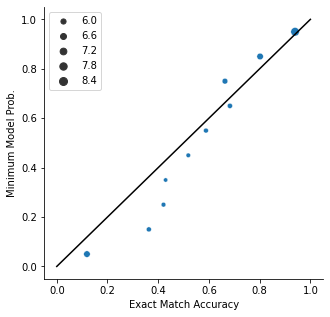

In [26]:
(values, 
bins, 
bin_number) = stats.binned_statistic(
    probs, 
    accs, 
    statistic='mean', 
    bins=10)

df_to_plot = bins_to_df(values, bins, bin_number)
plot_df(df_to_plot, ylabel="Minimum Model Prob.", xlabel="Exact Match Accuracy") 


In [36]:
import numpy as np
np.random.seed(12)
# stratified sample 
# bin_number has bin assignment 
# values has the mean acc of the bin 
# bins has the bin edges 

examples_by_bin = defaultdict(list)
idxs_by_bin_number = defaultdict(list)
for i, bin_num in enumerate(bin_number):
    idxs_by_bin_number[bin_num].append(i)


for i, (acc, edge_start) in enumerate(zip(values, bins)):
    edge_end = bins[i+1]
    midpoint = (edge_start + edge_end) / 2
    midpoint = f"{midpoint:.2f}"
    examples_by_bin[midpoint] = idxs_by_bin_number[i+1]

gold_src = read_gold_file("/brtx/601-nvme1/estengel/resources/data/smcalflow.agent.data.from_benchclamp/dev_all.src_tok")
gold_tgt = read_gold_file("/brtx/601-nvme1/estengel/resources/data/smcalflow.agent.data.from_benchclamp/dev_all.tgt") 
nucleus = read_nucleus_file("/brtx/604-nvme1/estengel/calflow_calibration/miso/tune_roberta_tok_fix_benchclamp_data/translate_output_calibrated/dev_all.tgt")

# we want 100 total examples, 10 per bin 
n_samples_per_bin = 10 

sampled_source = defaultdict(list)
sampled_target = defaultdict(list)
sampled_nucleus = defaultdict(list)
for midpoint, idxs in examples_by_bin.items():
    # reduce to idxs that are not fences 
    before_len = len(idxs)
    idxs = [i for i in idxs if "Fence" not in gold_tgt[i] and "Pleasantry" not in gold_tgt[i]]
    after_len = len(idxs)
    assert(before_len > after_len)

    sampled_idxs = np.random.choice(idxs, size=n_samples_per_bin, replace=False)
    for idx in sampled_idxs:
        sampled_source[midpoint].append(gold_src[idx])
        sampled_target[midpoint].append(gold_tgt[idx])
        nucleus_list = nucleus[gold_src[idx]]
        sampled_nucleus[midpoint].append(nucleus_list)

# write tgt 
out_file = "../hit/data/for_hit_round_2/stratified_data_by_bin.tgt"
tgt_out_file = "../hit/data/for_hit_round_2/stratified_gold.tgt"
src_out_file = "../hit/data/for_hit_round_2/stratified_gold.src_tok"
with open(out_file, "w") as f1, open(tgt_out_file, "w") as tgtf, open(src_out_file, "w") as srcf:
    for midpoint, nuc_list in sampled_nucleus.items():
        for nuc_sublist in nuc_list:
            for nuc, min_prob, total_prob in nuc_sublist:
                nuc['midpoint'] = float(midpoint) 
                nuc['min_prob'] = min_prob
                nuc = json.dumps(nuc)
                f1.write(nuc + "\n")
        tgt_str_list = sampled_target[midpoint]
        for tgt_str in tgt_str_list:
            tgtf.write(tgt_str.strip() + "\n")

        src_str_list = sampled_source[midpoint]
        for src_str in src_str_list:
            srcf.write(src_str.strip() + "\n")